# Coffea-Casa Benchmark Example 5

In [1]:
import numpy as np
%matplotlib inline
import hist
import coffea.processor as processor
import awkward as ak
from coffea.nanoevents import schemas

In [2]:
# This program will plot the MET for events which have an opposite-sign muon pair that has mass in the range of 60-120 GeV.

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.axis.StrCategory(name="dataset", label="", categories=[], growth=True)
        MET_axis = hist.axis.Regular(name="MET", label="MET [GeV]", bins=50, start=0, stop=125)
        
        self.output = processor.dict_accumulator({
            'MET': hist.Hist(dataset_axis, MET_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })

    def process(self, events):
        dataset = events.metadata["dataset"]
        
        muons = events.Muon
        MET = events.MET.pt
        
        self.output['cutflow']['all events'] += ak.size(muons, axis=0)
        self.output['cutflow']['all muons'] += ak.sum(ak.num(muons, axis=1))
        
        # Get all combinations of muon pairs in every event.
        dimuons = ak.combinations(muons, 2, fields=['i0', 'i1'])
        
        # Check that pairs have opposite charge.
        opposites = (dimuons['i0'].charge != dimuons['i1'].charge)
        
        # Get only muons with mass between 60 and 120. Add the dimuon p4's, take mass.
        limits = ((dimuons['i0'] + dimuons['i1']).mass >= 60) & ((dimuons['i0'] + dimuons['i1']).mass < 120)
        
        # Mask the dimuons with the opposites and the limits to get dimuons with opposite charge and mass between 60 and 120 GeV.
        good_dimuons = dimuons[opposites & limits]
        
        # Mask the MET to get it only if an associated dimuon pair meeting the conditions exists.
        good_MET = MET[ak.num(good_dimuons, axis=1) >= 1]
        
        self.output['cutflow']['final events'] += ak.size(good_MET, axis=0)
        
        self.output['MET'].fill(dataset=dataset, MET=good_MET)
        
        return self.output

    def postprocess(self, accumulator):
        pass

In [3]:
from dask.distributed import Client

client = Client("tls://localhost:8786")

In [4]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

executor = processor.DaskExecutor(client=client)

run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                        savemetrics=True
                      )

output, metrics = run(fileset, "Events", processor_instance=Processor())

metrics

{'bytesread': 2802762505,
 'columns': ['Muon_mass',
  'Muon_charge',
  'Muon_eta',
  'Muon_pt',
  'nMuon',
  'Muon_phi',
  'MET_pt'],
 'entries': 53446198,
 'processtime': 1935.6513311862946,
 'chunks': 534}

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f789caf7f40>, errorbar=None, legend_artist=None)]

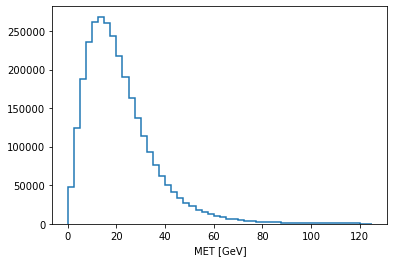

In [5]:
output['MET'].plot1d()

In [6]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
all muons 74439173
final events 2970884
